In [16]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import load_model

import matplotlib.pyplot as plt
import random
import pandas as pd
from models.unet_model import UNet
from utils.config import config
from utils.loader import DataLoader
from utils.tools import generator_img_baseline_data, dice_binary
from utils.unet_helper_functions import get_unet_model_path, get_unet_training_log_path, print_model_metric_analysis, \
print_models_average_metric_analysis, get_effNet_model_path, get_effNet_training_log_path

from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework


In [2]:
batch_size = config['unet_batch_size']
batch_size_val = config['unet_batch_size']
input_shape = config['input_shape']
num_train = config['num_train']
num_val = config['num_val']

cross_validation_folds = config['cross_validation_folds']

In [3]:
num_epochs = 10

# effnet model
base_model_name = 'B0'
encoder = EffnetEncoder(base_model_name, input_shape).build_encoder(trainable=True)

# MTL framework to custom build a model
effnet_builder = MTLFramework(encoder, input_shape)
effnet_builder.add_segmentation_head()
model = effnet_builder.build_mtl_model()

2022-01-12 10:59:54.893372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-12 10:59:54.893936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [6]:
model_histories = []
for fold in range(cross_validation_folds):
      print(f"-------------------- start cross val {fold+1} --------------------")
      loader1 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=1, CV_iteration=fold, fold=cross_validation_folds)
      loader2 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=2, CV_iteration=fold, fold=cross_validation_folds)

      # get training data
      train_imgs = loader1.get_image_ds().repeat()
      train_masks = loader1.get_mask_ds().repeat()

      # get validation data
      val_imgs = loader2.get_image_ds().repeat()
      val_masks = loader2.get_mask_ds().repeat()

      # CLEARS OLD MODELS IN CACHE
      tf.keras.backend.clear_session()

      model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=[{'accuracy': 'accuracy', 'dice_binary': dice_binary}])
      model.summary()

      # we have a checkpointer that saves the best effNet model
      # and a cvs_logger that saves the history of each unet model
      checkpointer = ModelCheckpoint(get_effNet_model_path(fold), verbose=1, save_best_only=True)
      csv_logger = CSVLogger(get_effNet_training_log_path(fold), separator=',', append=False)

      # fit training and validation data
      history = model.fit(generator_img_baseline_data(train_imgs, train_masks), validation_data=generator_img_baseline_data(val_imgs, val_masks), batch_size=batch_size, epochs=num_epochs, callbacks=[checkpointer, csv_logger], steps_per_epoch=num_train//batch_size, validation_steps=num_val//batch_size_val)

      model_histories.append(history.history)

-------------------- start cross val 1 --------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 EffnetB0Encoder (Functional)   [(None, 128, 128, 9  3633571     ['input[0][0]']                  
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (

2022-01-12 11:50:52.787301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


138/138 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9723 - dice_binary: 0.9591

2022-01-12 11:53:08.705843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.20891, saving model to model_weights/effNet/CV/best_EFFNET_1.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_1.tf/assets
138/138 [==============================] - 171s 1s/step - loss: 0.0750 - accuracy: 0.9723 - dice_binary: 0.9591 - val_loss: 0.2089 - val_accuracy: 0.9353 - val_dice_binary: 0.9120


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/10
138/138 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9727 - dice_binary: 0.9559
Epoch 00002: val_loss did not improve from 0.20891
138/138 [==============================] - 153s 1s/step - loss: 0.0735 - accuracy: 0.9727 - dice_binary: 0.9559 - val_loss: 0.2205 - val_accuracy: 0.9395 - val_dice_binary: 0.9190
Epoch 3/10
138/138 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9739 - dice_binary: 0.9607
Epoch 00003: val_loss improved from 0.20891 to 0.17242, saving model to model_weights/effNet/CV/best_EFFNET_1.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_1.tf/assets
138/138 [==============================] - 166s 1s/step - loss: 0.0710 - accuracy: 0.9739 - dice_binary: 0.9607 - val_loss: 0.1724 - val_accuracy: 0.9487 - val_dice_binary: 0.9337


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/10
138/138 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9721 - dice_binary: 0.9549
Epoch 00004: val_loss did not improve from 0.17242
138/138 [==============================] - 153s 1s/step - loss: 0.0755 - accuracy: 0.9721 - dice_binary: 0.9549 - val_loss: 0.2703 - val_accuracy: 0.9270 - val_dice_binary: 0.9024
Epoch 5/10
138/138 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9726 - dice_binary: 0.9596
Epoch 00005: val_loss did not improve from 0.17242
138/138 [==============================] - 153s 1s/step - loss: 0.0744 - accuracy: 0.9726 - dice_binary: 0.9596 - val_loss: 0.1889 - val_accuracy: 0.9436 - val_dice_binary: 0.9263
Epoch 6/10
138/138 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9724 - dice_binary: 0.9560
Epoch 00006: val_loss did not improve from 0.17242
138/138 [==============================] - 153s 1s/step - loss: 0.0741 - accuracy: 0.9724 - dice_binary: 0.9560 - val_loss: 0.2274 - 

2022-01-12 12:16:51.860577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


138/138 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9548 - dice_binary: 0.9377

2022-01-12 12:19:08.689859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.08231, saving model to model_weights/effNet/CV/best_EFFNET_2.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_2.tf/assets
138/138 [==============================] - 172s 1s/step - loss: 0.1264 - accuracy: 0.9548 - dice_binary: 0.9377 - val_loss: 0.0823 - val_accuracy: 0.9721 - val_dice_binary: 0.9633


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/10
138/138 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9715 - dice_binary: 0.9549
Epoch 00002: val_loss improved from 0.08231 to 0.08146, saving model to model_weights/effNet/CV/best_EFFNET_2.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_2.tf/assets
138/138 [==============================] - 167s 1s/step - loss: 0.0770 - accuracy: 0.9715 - dice_binary: 0.9549 - val_loss: 0.0815 - val_accuracy: 0.9664 - val_dice_binary: 0.9528


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/10
138/138 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9720 - dice_binary: 0.9576
Epoch 00003: val_loss improved from 0.08146 to 0.07514, saving model to model_weights/effNet/CV/best_EFFNET_2.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_2.tf/assets
138/138 [==============================] - 166s 1s/step - loss: 0.0744 - accuracy: 0.9720 - dice_binary: 0.9576 - val_loss: 0.0751 - val_accuracy: 0.9695 - val_dice_binary: 0.9579


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/10
138/138 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9753 - dice_binary: 0.9602
Epoch 00004: val_loss did not improve from 0.07514
138/138 [==============================] - 153s 1s/step - loss: 0.0662 - accuracy: 0.9753 - dice_binary: 0.9602 - val_loss: 0.0941 - val_accuracy: 0.9623 - val_dice_binary: 0.9468
Epoch 5/10
138/138 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9750 - dice_binary: 0.9612
Epoch 00005: val_loss did not improve from 0.07514
138/138 [==============================] - 153s 1s/step - loss: 0.0675 - accuracy: 0.9750 - dice_binary: 0.9612 - val_loss: 0.0840 - val_accuracy: 0.9665 - val_dice_binary: 0.9534
Epoch 6/10
138/138 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9761 - dice_binary: 0.9621
Epoch 00006: val_loss did not improve from 0.07514
138/138 [==============================] - 153s 1s/step - loss: 0.0655 - accuracy: 0.9761 - dice_binary: 0.9621 - val_loss: 0.0889 - 

2022-01-12 12:43:07.229175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


138/138 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9680 - dice_binary: 0.9564

2022-01-12 12:45:24.594803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.08509, saving model to model_weights/effNet/CV/best_EFFNET_3.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_3.tf/assets
138/138 [==============================] - 174s 1s/step - loss: 0.0835 - accuracy: 0.9680 - dice_binary: 0.9564 - val_loss: 0.0851 - val_accuracy: 0.9713 - val_dice_binary: 0.9521


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/10
138/138 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9718 - dice_binary: 0.9615
Epoch 00002: val_loss improved from 0.08509 to 0.07267, saving model to model_weights/effNet/CV/best_EFFNET_3.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_3.tf/assets
138/138 [==============================] - 166s 1s/step - loss: 0.0742 - accuracy: 0.9718 - dice_binary: 0.9615 - val_loss: 0.0727 - val_accuracy: 0.9738 - val_dice_binary: 0.9555


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/10
138/138 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9754 - dice_binary: 0.9662
Epoch 00003: val_loss improved from 0.07267 to 0.07098, saving model to model_weights/effNet/CV/best_EFFNET_3.tf
INFO:tensorflow:Assets written to: model_weights/effNet/CV/best_EFFNET_3.tf/assets
138/138 [==============================] - 167s 1s/step - loss: 0.0651 - accuracy: 0.9754 - dice_binary: 0.9662 - val_loss: 0.0710 - val_accuracy: 0.9745 - val_dice_binary: 0.9569


/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/faresfawzi/miniforge3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/10
138/138 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9760 - dice_binary: 0.9672
Epoch 00004: val_loss did not improve from 0.07098
138/138 [==============================] - 153s 1s/step - loss: 0.0642 - accuracy: 0.9760 - dice_binary: 0.9672 - val_loss: 0.0759 - val_accuracy: 0.9734 - val_dice_binary: 0.9547
Epoch 5/10
138/138 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9768 - dice_binary: 0.9685
Epoch 00005: val_loss did not improve from 0.07098
138/138 [==============================] - 153s 1s/step - loss: 0.0623 - accuracy: 0.9768 - dice_binary: 0.9685 - val_loss: 0.0778 - val_accuracy: 0.9730 - val_dice_binary: 0.9544
Epoch 6/10
138/138 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9747 - dice_binary: 0.9641
Epoch 00006: val_loss did not improve from 0.07098
138/138 [==============================] - 153s 1s/step - loss: 0.0683 - accuracy: 0.9747 - dice_binary: 0.9641 - val_loss: 0.1267 - 

In [7]:
# Printing the Metric analysis per fold and average
print('Scores per fold:\n')
for i in range(cross_validation_folds):
   history = model_histories[i]
   print(f'For fold {i+1}:')
   print_model_metric_analysis(history)

print('Average Scores for EffNet:')
# print_models_average_metric_analysis(model_histories, cross_validation_folds)

# pick best model out of the 3 - used loss we can use some other factor
average_loss_per_model = [np.mean(model_histories[i]["loss"]) for i in range(cross_validation_folds)]
best_model_idx = np.argmin(average_loss_per_model)

best_model_history = model_histories[best_model_idx]
epochs = np.arange(0, num_epochs)

Scores per fold:

For fold 1:
	Training:
		Accuracy: 97.32183396816254 %
		Loss: 7.248323932290076 %
		Dice Binary: 95.87082028388977 %

	Validation:
		Accuracy: 93.84795308113098 %
		Loss: 21.32993295788765 %
		Dice Binary: 91.8481034040451 %

For fold 2:
	Training:
		Accuracy: 97.03231036663055 %
		Loss: 8.045472353696823 %
		Dice Binary: 95.46136200428009 %

	Validation:
		Accuracy: 96.0672378540039 %
		Loss: 12.97280341386795 %
		Dice Binary: 94.87680196762085 %

For fold 3:
	Training:
		Accuracy: 97.40426361560822 %
		Loss: 6.890230104327203 %
		Dice Binary: 96.42766952514648 %

	Validation:
		Accuracy: 96.93018794059753 %
		Loss: 8.975211158394814 %
		Dice Binary: 94.85597133636475 %

Average Scores for EffNet:


In [19]:
import pandas as pd
log_path=get_unet_training_log_path(2)
log_data = pd.read_csv(log_path, sep=',', engine='python')

log_data

,epoch,accuracy,dice_binary,loss,val_accuracy,val_dice_binary,val_loss
0,0,0.881145,0.846514,0.278331,0.857628,0.797940,0.368073
1,1,0.881033,0.845961,0.278893,0.886927,0.835754,0.297024
2,2,0.902506,0.875614,0.235452,0.883338,0.820413,0.287513
3,3,0.897370,0.865065,0.244713,0.899224,0.845772,0.257290
4,4,0.910932,0.885911,0.215742,0.883304,0.814997,0.280153
5,5,0.916882,0.888627,0.204399,0.900811,0.844946,0.275486
6,6,0.921775,0.898989,0.193969,0.882296,0.810490,0.283856
7,7,0.924442,0.897755,0.187877,0.886718,0.816588,0.272393
8,8,0.931299,0.910526,0.170169,0.889311,0.822534,0.280715
9,9,0.930317,0.905701,0.175117,0.891044,0.824607,0.261286


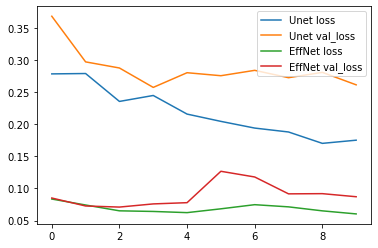

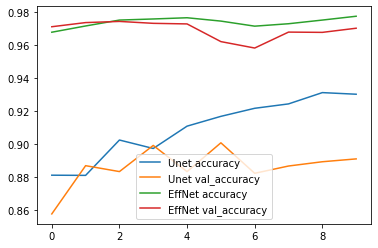

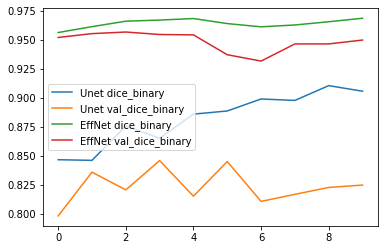

In [20]:
#plotting Unet and Effnet

plt.plot(epochs, log_data['loss'], label='Unet loss')
plt.plot(epochs, log_data['val_loss'], label='Unet val_loss')

plt.plot(epochs, best_model_history['loss'], label='EffNet loss')
plt.plot(epochs, best_model_history['val_loss'], label='EffNet val_loss')
plt.legend()
plt.show()

plt.plot(epochs, log_data['accuracy'], label='Unet accuracy')
plt.plot(epochs, log_data['val_accuracy'], label='Unet val_accuracy')


plt.plot(epochs, best_model_history['accuracy'], label='EffNet accuracy')
plt.plot(epochs, best_model_history['val_accuracy'], label='EffNet val_accuracy')
plt.legend()
plt.show()


plt.plot(epochs, log_data['dice_binary'], label='Unet dice_binary')
plt.plot(epochs, log_data['val_dice_binary'], label='Unet val_dice_binary')

plt.plot(epochs, best_model_history['dice_binary'], label='EffNet dice_binary')
plt.plot(epochs, best_model_history['val_dice_binary'], label='EffNet val_dice_binary')
plt.legend()
plt.show()

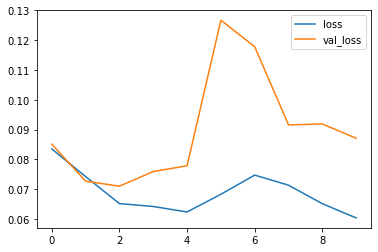

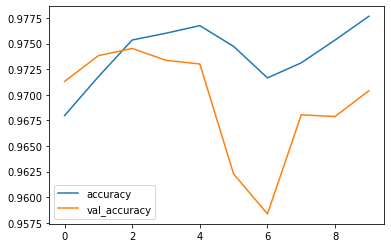

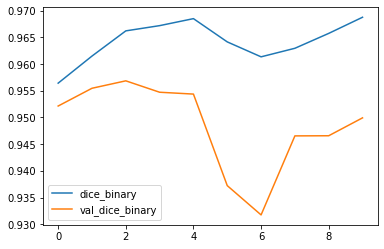

In [8]:
# plot all metrics for the best model
plt.plot(epochs, best_model_history['loss'], label='loss')
plt.plot(epochs, best_model_history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(epochs, best_model_history['accuracy'], label='accuracy')
plt.plot(epochs, best_model_history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(epochs, best_model_history['dice_binary'], label='dice_binary')
plt.plot(epochs, best_model_history['val_dice_binary'], label='val_dice_binary')
plt.legend()
plt.show()

2022-01-12 14:51:04.539079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy 95.67274833840226%


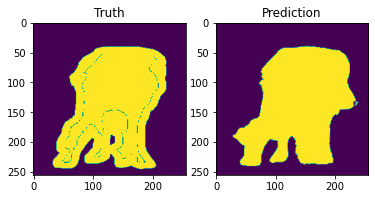

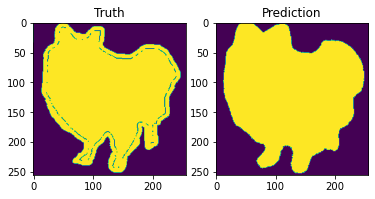

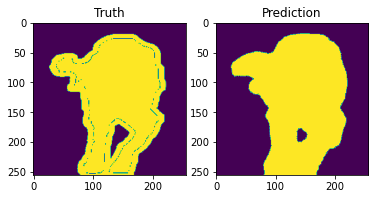

In [22]:
# load best model
best_model = load_model(get_effNet_model_path(2), custom_objects={"dice_binary": dice_binary})

# Load and get test data
loader = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=0, CV_iteration=0)

img_ds_test = loader.get_image_ds(test_mode=True)
masks_ds_test = loader.get_mask_ds(test_mode=True)

# Predict using best UNet model
test_preds = best_model.predict(img_ds_test, batch_size=batch_size)
formatted_test_preds = (test_preds >= 0.5).astype(np.uint8)

# Compute and print test accuracy
test_accuracy = np.sum(formatted_test_preds == masks_ds_test) / (masks_ds_test.shape[0] * (255 * 255))
print(f"Accuracy {test_accuracy * 100}%")


# plot 3 ground truth/prediction masks
idx = list(range(img_ds_test.shape[0]))
random.shuffle(idx)
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(tf.keras.utils.array_to_img( masks_ds_test[idx[i]]))
    ax1.set_title('Truth')
    ax2.imshow(tf.keras.utils.array_to_img(formatted_test_preds[idx[i]]))
    ax2.set_title('Prediction')

    plt.show()

In [11]:
model.evaluate(x=img_ds_test, y=masks_ds_test, batch_size=batch_size)

2022-01-12 14:20:22.544072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 20s 388ms/step - loss: 0.1744 - accuracy: 0.9477 - dice_binary: 0.9340


[0.1743895560503006, 0.947706937789917, 0.9339515566825867]